Time series forecasting. Starting from stocks returns we want to forecast the return using arma model. The returns used are daily. 


In [27]:
import sys
!{sys.executable} -m pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as sst
from pandas_datareader import data as pdr
from scipy.stats import norm
from datetime import date
import math
import statsmodels as ss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA


You should consider upgrading via the 'C:\Users\marti\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
stock = input('What stock should the model be performed on?: ')

What stock should the model be performed on?: AMZN


In [3]:
#deciding how big the training sample should be

length_training_sample = int(input('How many days should the training sample be:?'))


end_training = dt.date(2018,1,1)
start_training = end_training - dt.timedelta(days = length_training_sample)

#out of sample forecast dates
start_forecast = end_training + dt.timedelta(days = 1)
end_forecast = date.today()

print('The start of the training is ' + str(start_training) +', the end of the training is ' + str(end_training) +
      ', the start of forecast is ' + str(start_forecast) + ', the end of the forecast is ' + str(end_forecast))

How many days should the training sample be:?800
The start of the training is 2015-10-24, the end of the training is 2018-01-01, the start of forecast is 2018-01-02, the end of the forecast is 2021-11-27


In [4]:
#downloading the returns for the stock
stock_data = pdr.get_data_yahoo(stock,start_training,end_training)
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-10-26,609.849976,596.289978,602.299988,608.609985,4269700,608.609985
2015-10-27,614.710022,605.530029,608.599976,611.010010,3787100,611.010010
2015-10-28,617.229980,609.500000,612.299988,617.099976,3926200,617.099976
2015-10-29,627.539978,615.390015,617.700012,626.549988,3896000,626.549988
2015-10-30,630.719971,625.280029,626.010010,625.900024,3874400,625.900024
...,...,...,...,...,...,...
2017-12-22,1174.619995,1167.829956,1172.079956,1168.359985,1585100,1168.359985
2017-12-26,1178.319946,1160.550049,1168.359985,1176.760010,2005200,1176.760010
2017-12-27,1187.290039,1175.609985,1179.910034,1182.260010,1867200,1182.260010


In [5]:
#keeping only the close column
stock_data_close = stock_data.Close
stock_data_close


Date
2015-10-26     608.609985
2015-10-27     611.010010
2015-10-28     617.099976
2015-10-29     626.549988
2015-10-30     625.900024
                 ...     
2017-12-22    1168.359985
2017-12-26    1176.760010
2017-12-27    1182.260010
2017-12-28    1186.099976
2017-12-29    1169.469971
Name: Close, Length: 550, dtype: float64

In [6]:
#features of the returns
stock_data_close.describe()

count     550.000000
mean      818.648364
std       167.411259
min       482.070007
25%       696.925003
50%       789.779999
75%       963.464981
max      1195.829956
Name: Close, dtype: float64

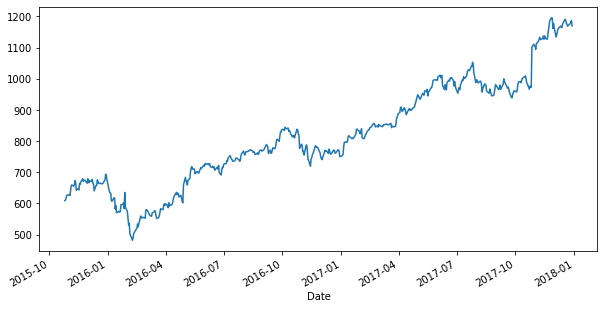

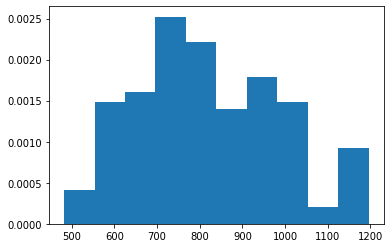

In [15]:
#graph of the prices
stock_data_close.plot(figsize=(10,5))
plt.show()
stock_price_hist = plt.hist(stock_data_close,density = True)

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

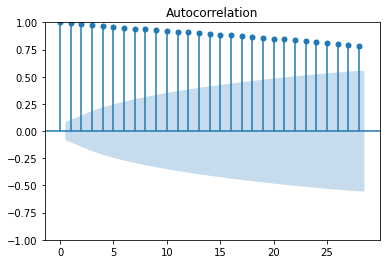

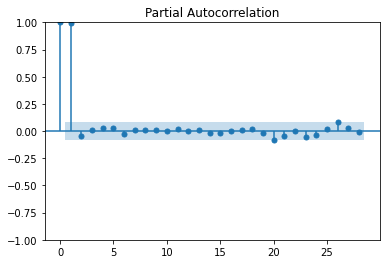

In [16]:
#acf and pacf of the prices
plot_acf(stock_data_close)
plot_pacf(stock_data_close)
plt.show

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

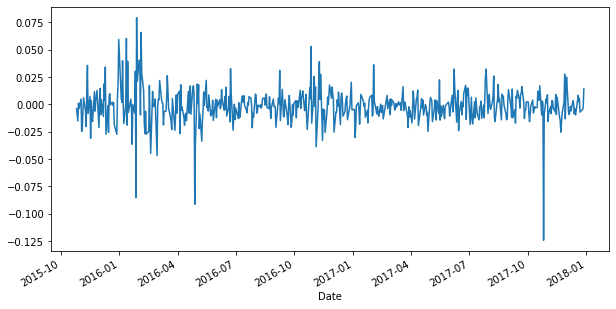

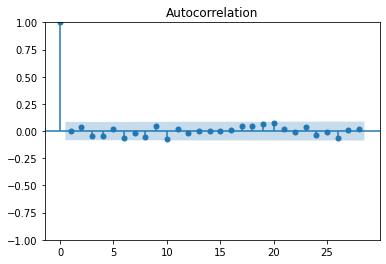

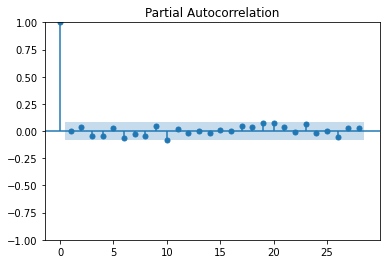

In [26]:
#getting the returns and plotting the returns + acf and pacf
returns = np.log(stock_data_close/stock_data_close.shift(-1))
returns = returns.dropna()
returns 
returns.plot(figsize=(10,5))
plot_acf(returns)
plot_pacf(returns)
plt.show

In [31]:
#testing for normality of returns


#calculating skewness
skewness_returns = sst.skew(returns)

#calculating kurtosis
kurtosis_returns = sst.kurtosis(returns)

print('The skewness of the returns is '+str(skewness_returns) + ' and the kurtosis is '+ str(kurtosis_returns))

The skewness of the returns is -0.7110875454919173 and the kurtosis is 11.114274826192858


In [11]:
#stationarity tests, H0 is there is a unit root
adf_test = ss.tsa.stattools.adfuller(returns,None,'c',None,False,False)
adf_test
print('The p-value is '+str(adf_test[1]))

The p-value is 0.00023465352266524895


In [12]:
#fitting arima model
returns = returns.asfreq('d')
model_arima = ARIMA(returns,order=(3,1,1))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  795
Model:                 ARIMA(3, 1, 1)   Log Likelihood                1484.926
Date:                Sat, 27 Nov 2021   AIC                          -2959.851
Time:                        19:54:35   BIC                          -2936.466
Sample:                    10-26-2015   HQIC                         -2950.865
                         - 12-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0109      0.034      0.318      0.750      -0.056       0.078
ar.L2          0.0644      0.054      1.204      0.229      -0.040       0.169
ar.L3         -0.0043      0.056     -0.077      0.9

C:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
